In [26]:
# Import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from datetime import timedelta
warnings.filterwarnings('ignore')

In [3]:
# Read in the file
file = 'rhessi_flare_list.txt'
flare = pd.read_table(file, sep='\s+', skiprows=7, names=['Flare', 'Date', 'Start', 'PeakTime', 'End', 'Dur', 'Peak', 'Total','Energy', 'XPos', 'YPos', 'Radial', 'AR', 'Flag1', 'Flag2', 'Flag3', 'Flag4', 'Flag5', 'Flag6', 'Flag7', 'Flag8', 'Flag9', 'Flag10', 'Flag11'] , engine='python', skipfooter=39)
print(flare.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121180 entries, 0 to 121179
Data columns (total 24 columns):
Flare       121180 non-null int64
Date        121180 non-null object
Start       121180 non-null object
PeakTime    121180 non-null object
End         121180 non-null object
Dur         121180 non-null int64
Peak        121180 non-null int64
Total       121180 non-null int64
Energy      121180 non-null object
XPos        121180 non-null int64
YPos        121180 non-null int64
Radial      121180 non-null int64
AR          121180 non-null int64
Flag1       121180 non-null object
Flag2       121180 non-null object
Flag3       101273 non-null object
Flag4       100978 non-null object
Flag5       58334 non-null object
Flag6       20033 non-null object
Flag7       4010 non-null object
Flag8       897 non-null object
Flag9       129 non-null object
Flag10      22 non-null object
Flag11      2 non-null object
dtypes: int64(8), object(16)
memory usage: 22.2+ MB
None


In [4]:
# Drop flares in energy band 3-6 keV since they are not considered as of Solar origin
flare = flare.loc[flare['Energy']!='3-6']
# Drop flares with Peak count rate = 0
flare = flare.loc[flare['Peak']!=0]

# Convert Energy to a categorical feature
flare['Energy'] = pd.Categorical(flare['Energy'], ordered=True, categories=['6-12', '12-25', '25-50','50-100', '100-300', '300-800', '800-7000', '7000-20000'])       

# Combine all flags into one column and remove 'None', 'NA', '' entries
Flags = flare.iloc[:,13:].fillna(0)
Flags = Flags.apply(list, axis=1)
Flags = Flags.apply(lambda i:[j for j in i if j!=0 and j!=''])

# Drop unnecessary columns
flare.drop(['Flag1', 'Flag2', 'Flag3', 'Flag4', 'Flag5', 'Flag6', 'Flag7', 'Flag8', 'Flag9', 'Flag10', 'Flag11'], axis=1, inplace=True)
flare['Flags'] = Flags
flare.drop(['XPos', 'YPos', 'Radial'], axis=1, inplace=True)
flare.reset_index(drop=True, inplace=True)

In [5]:
# Keep only Quality 1 'Q1' flares and those in attenuator state 'A0'
# Create a boolean list 'sub' to store observations flagged as 'Q1' and 'A0'
sub = []
for i in range(len(flare['Flags'])):
    if 'Q1' in flare['Flags'][i] and 'A0' in flare['Flags'][i]:
        sub.append(True)
    else:
        sub.append(False)
flare = flare.loc[sub]
flare.reset_index(drop=True, inplace=True)

In [6]:
# Check Flag values to remove 'NS' and 'PS' as they are non-solar events
def non_solar(df, column, tags):
    """
    Function to check if any of the entries are tagged as non-solar.
    Input:
    df : dataframe
    column : name of column to check for flags
    tags : list of tags to be removed
    Output:
    prints the result of the check performed
    """
    check = {}
    for i in range(len(df[column])):
        for tag in tags:
            if tag in df.loc[i, column]:
                check[i] = tag
    return check

check = non_solar(flare, 'Flags', ['NS', 'PS'])
if check == {}:
    print("No non-solar events found!")
else:
    print(check)

No non-solar events found!


In [7]:
# Drop flare observations that started or ended when the spacecraft was in South Atlantic Anomaly
saa = non_solar(flare, 'Flags', ['SS', 'SE'])
flare.drop(saa.keys(), axis=0, inplace=True)
flare.reset_index(drop=True, inplace=True)

In [8]:
# Drop Flags column after cleaning the data        
flare.drop('Flags', axis=1, inplace=True)
# Convert Start to datetime format
flare['Start'] = pd.to_datetime(flare['Date']+' '+flare['Start'])

In [9]:
# Convert PeakTime to datetime format
# May take up to 6 minutes
for name, row in flare.iterrows():
    flare.loc[name, 'PeakTime'] = pd.to_datetime(flare.loc[name, 'Date']+' '+flare.loc[name, 'PeakTime']) 
    if flare.loc[name, 'PeakTime'] < flare.loc[name, 'Start']:
        flare.loc[name, 'PeakTime'] = flare.loc[name, 'PeakTime'] + timedelta(days=1)
flare['PeakTime'] = pd.to_datetime(flare['PeakTime'])

In [10]:
# Convert End to datetime format 
flare['End'] = flare['Start'] + flare['Dur'].apply(lambda x: timedelta(seconds=x))

In [11]:
# Calculate new feature RiseTime (in seconds) = PeakTime - Start
flare['RiseTime'] = (flare['PeakTime'] - flare['Start']).apply(lambda x : x.total_seconds())
# Calculate new feature DecayTime (in seconds) = End - PeakTime
flare['DecayTime'] = (flare['End'] - flare['PeakTime']).apply(lambda x : x.total_seconds())
# Calculate new feature Year storing the year in which each flare occured
flare['Year'] = flare['Start'].apply(lambda x : x.year)

In [13]:
print(flare.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39952 entries, 0 to 39951
Data columns (total 13 columns):
Flare        39952 non-null int64
Date         39952 non-null object
Start        39952 non-null datetime64[ns]
PeakTime     39952 non-null datetime64[ns]
End          39952 non-null datetime64[ns]
Dur          39952 non-null int64
Peak         39952 non-null int64
Total        39952 non-null int64
Energy       39952 non-null category
AR           39952 non-null int64
RiseTime     39952 non-null float64
DecayTime    39952 non-null float64
Year         39952 non-null int64
dtypes: category(1), datetime64[ns](3), float64(2), int64(6), object(1)
memory usage: 3.7+ MB
None


In [14]:
print(flare.head())

     Flare         Date               Start            PeakTime  \
0  2021463  14-Feb-2002 2002-02-14 22:05:20 2002-02-14 22:14:14   
1  2021879  18-Feb-2002 2002-02-18 17:33:36 2002-02-18 17:36:18   
2  2021829  18-Feb-2002 2002-02-18 17:41:16 2002-02-18 17:42:50   
3  2021823  18-Feb-2002 2002-02-18 19:13:36 2002-02-18 19:16:54   
4  2021882  18-Feb-2002 2002-02-18 19:20:04 2002-02-18 19:24:58   

                  End   Dur  Peak   Total Energy    AR  RiseTime  DecayTime  \
0 2002-02-14 22:19:28   848    27   63720   6-12  9822     534.0      314.0   
1 2002-02-18 17:41:16   460    65   42574   6-12  9830     162.0      298.0   
2 2002-02-18 17:45:56   280     9   10542   6-12  9830      94.0      186.0   
3 2002-02-18 19:20:04   388   176  137568   6-12     0     198.0      190.0   
4 2002-02-18 19:37:20  1036   112  381168   6-12  9830     294.0      742.0   

   Year  
0  2002  
1  2002  
2  2002  
3  2002  
4  2002  


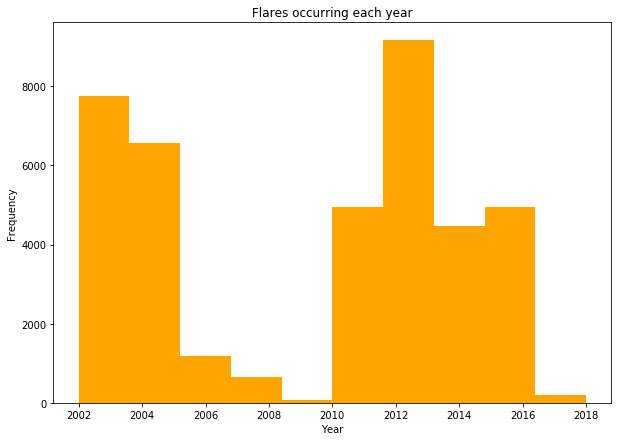

In [15]:
# Number of flares occurring each year
flare['Year'].plot(kind='hist', color='orange', figsize=(10,7))
plt.xlabel("Year")
plt.title("Flares occurring each year")
plt.show()

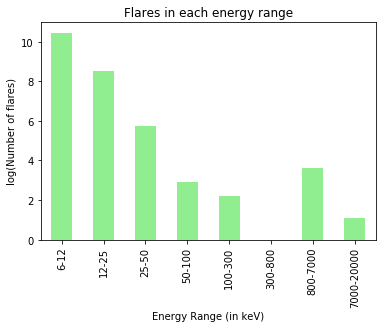

In [27]:
# Group and plot flare entries based on the energy range they have been observed in        
energy_range = flare['Energy'].value_counts()  
energy_range.sort_index(inplace=True)  
np.log(energy_range).plot(kind='bar', color='lightgreen', title='Flares by Energy Range') 
plt.xlabel('Energy Range (in keV)')
plt.ylabel('log(Number of flares)')
plt.title('Flares in each energy range')
plt.show()

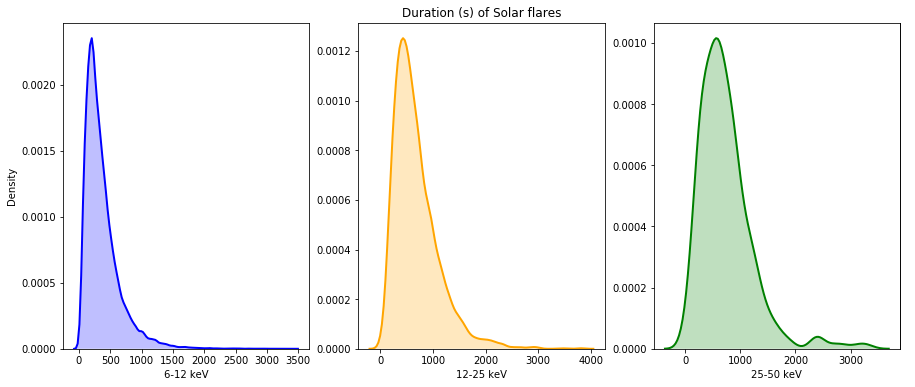

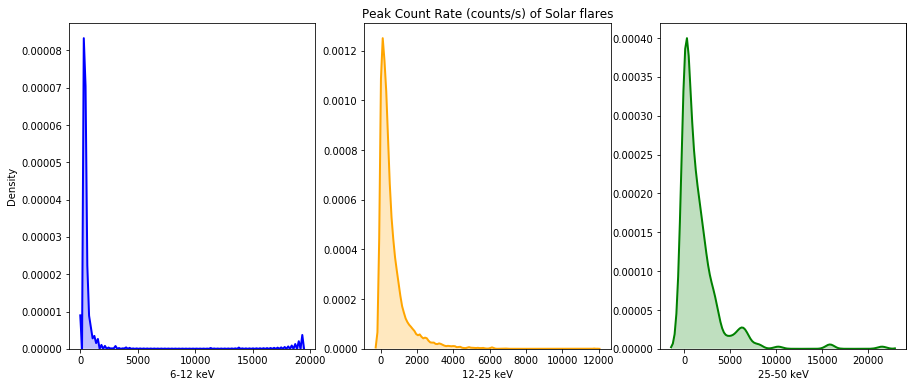

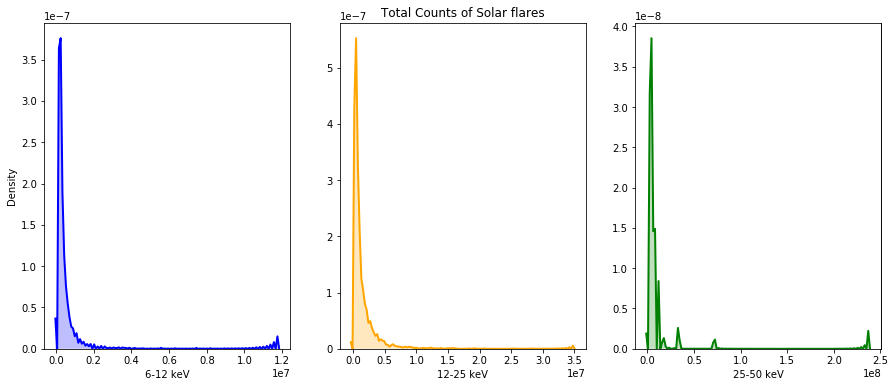

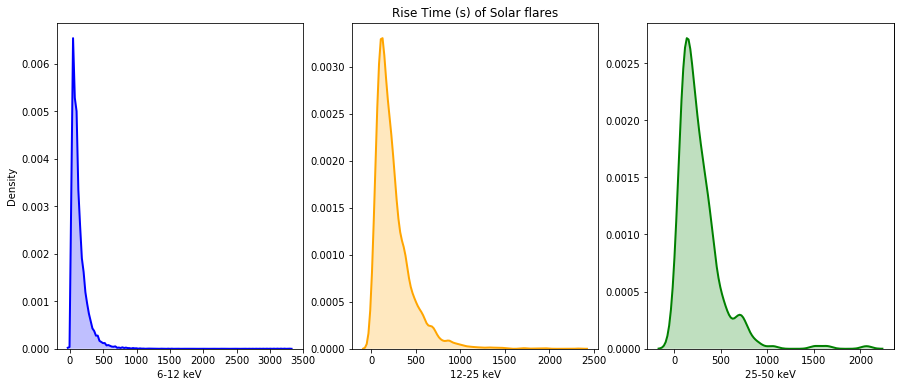

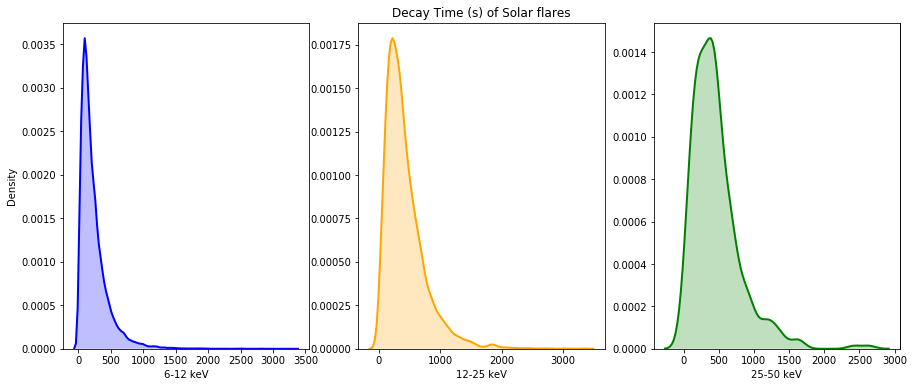

In [17]:
# Exploratory Data Analysis of numerical variables
def plot_eda(df, column, label):
    """
    Function to plot density plots of features.
    Input:
    df : dataframe
    column : name of feature to be plotted
    label : string to set as xlabel of the plot
    Output:
    plots density plots on a 1x3 dimensional plot
    """
    fig = plt.figure(figsize=(15, 6))
    ax = fig.add_subplot(111)
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
    ax.spines['top'].set_color('none')
    ax.set_title(label+" of Solar flares")
    ax.spines['bottom'].set_color('none')
    sns.distplot(df.loc[df['Energy']=='6-12', column], hist=False, kde_kws = {'shade': True, 'linewidth': 2}, ax=ax1, color='blue')
    sns.distplot(df.loc[df['Energy']=='12-25', column], hist=False, kde_kws = {'shade': True, 'linewidth': 2}, ax=ax2, color='orange')
    sns.distplot(df.loc[df['Energy']=='25-50', column], hist=False, kde_kws = {'shade': True, 'linewidth': 2}, ax=ax3, color='green')
    ax1.set_ylabel("Density")
    ax1.set_xlabel("6-12 keV")
    ax2.set_xlabel("12-25 keV")
    ax3.set_xlabel("25-50 keV")
    plt.show()

cols = ['Dur', 'Peak', 'Total', 'RiseTime', 'DecayTime']
labels = ['Duration (s)', 'Peak Count Rate (counts/s)', 'Total Counts', 'Rise Time (s)', 'Decay Time (s)']
for column in cols:
        plot_eda(flare, column, label = labels[cols.index(column)])

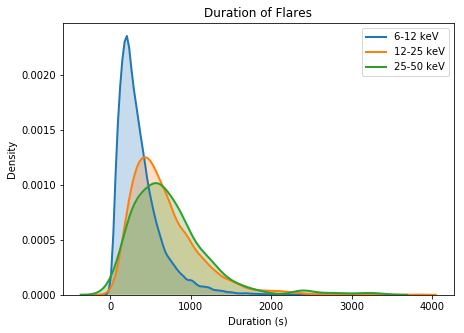

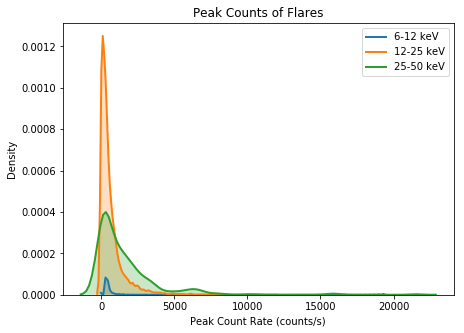

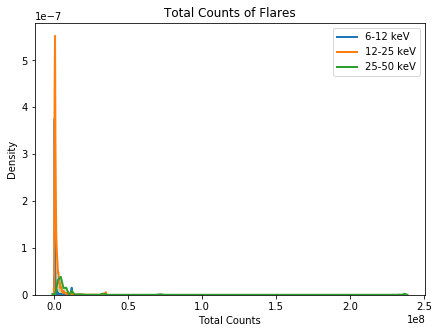

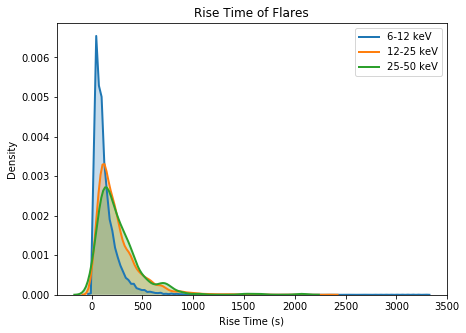

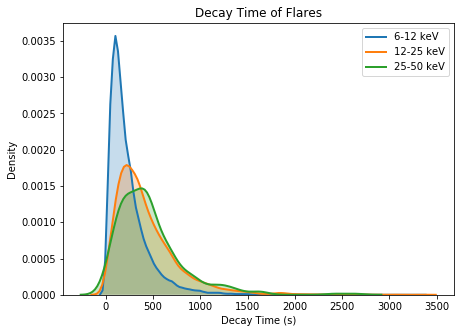

In [18]:
# Comparison of features between different energy ranges
def plot_compare(df, column, label, title):
    """
    Function to plot density plots of features.
    Input:
    df : dataframe
    column : name of feature to be plotted
    label : string to set as xlabel of the plot
    title : string to set as title of the plot
    Output:
    plots density plots on a 1x3 dimensional plot
    """
    plt.figure(figsize=(7,5))
    for energy in ['6-12', '12-25', '25-50']:
        sns.distplot(flare.loc[flare['Energy']==energy, column], hist=False, kde=True, kde_kws = {'shade': True, 'linewidth': 2}, label=energy+' keV')
    plt.xlabel(label)
    plt.ylabel("Density")
    plt.title(title)
    plt.legend()
    plt.show()

cols = ['Dur', 'Peak', 'Total', 'RiseTime', 'DecayTime']
labels = ['Duration (s)', 'Peak Count Rate (counts/s)', 'Total Counts', 'Rise Time (s)', 'Decay Time (s)']
titles = ["Duration of Flares", "Peak Counts of Flares", "Total Counts of Flares", "Rise Time of Flares", "Decay Time of Flares"]
for column in cols:
    plot_compare(flare, column, label = labels[cols.index(column)], title = titles[cols.index(column)])

 ************** Energy = 6-12 keV ******************


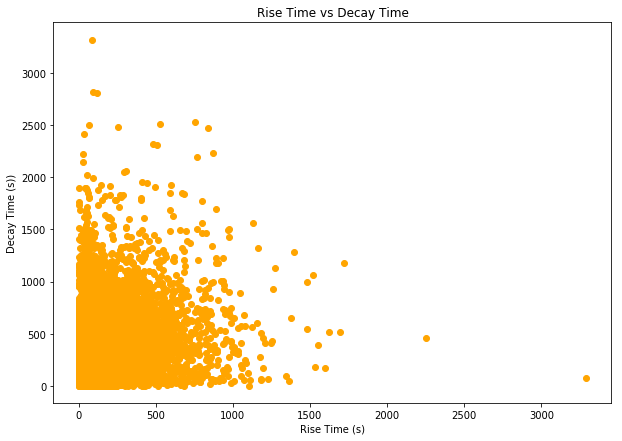

 ************** Energy = 12-25 keV ******************


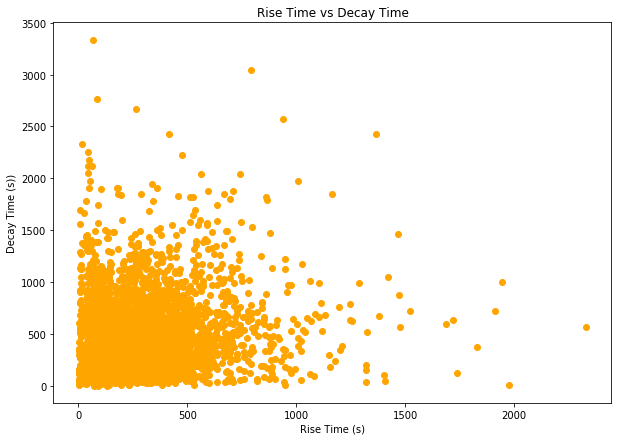

 ************** Energy = 25-50 keV ******************


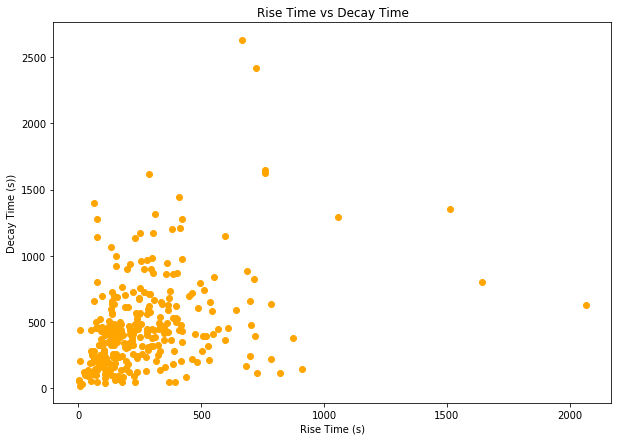

In [19]:
# Scatter plot between RiseTime and DecayTime
for energy in ['6-12', '12-25', '25-50']:
    print(" ************** Energy = "+ energy +" keV ******************")  
    plt.figure(figsize=(10,7))
    plt.scatter(x=flare.loc[flare['Energy']==energy, 'RiseTime'], y=flare.loc[flare['Energy']==energy, 'DecayTime'], c='orange')
    plt.xlabel("Rise Time (s)")
    plt.ylabel("Decay Time (s))")
    plt.title("Rise Time vs Decay Time")
    plt.show()

 ************** Energy = 6-12 keV ******************


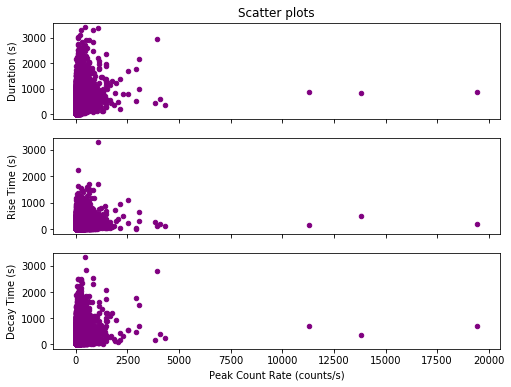


 ************** Energy = 12-25 keV ******************


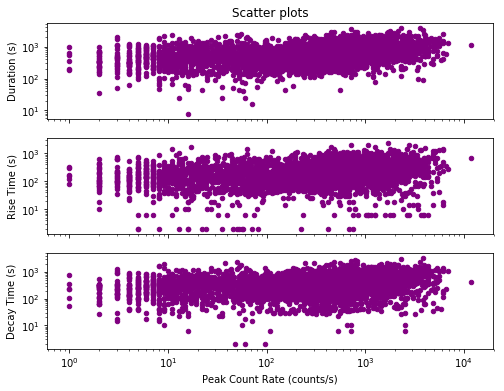


 ************** Energy = 25-50 keV ******************


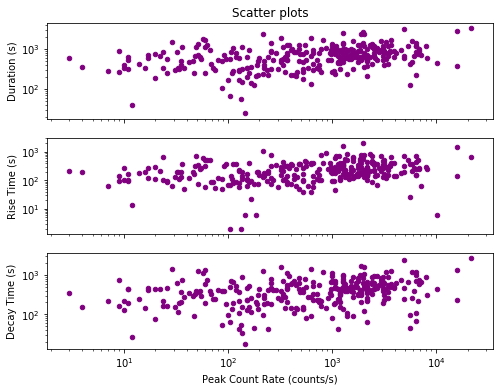

In [20]:
# Plot scatter plots between Peak Counts, Duration, RiseTime and DecayTime of flares in energy ranges '6-12', '12-25', '25-50' keV
for energy in ['6-12', '12-25', '25-50']:
    print(" ************** Energy = "+ energy +" keV ******************")  
    fig, ax = plt.subplots(3,1, sharex=True)
    if energy=='6-12': 
        log=False
    else:
        log=True
    flare.loc[flare['Energy'] == energy,:].plot(ax=ax[0], x='Peak', y='Dur', kind='scatter', loglog=log, figsize=(8,6), color='purple')
    ax[0].set_ylabel('Duration (s)')
    ax[0].set_title('Scatter plots')
    flare.loc[flare['Energy'] == energy,:].plot(ax=ax[1], x='Peak', y='RiseTime', kind='scatter', loglog=log, color='purple')
    ax[1].set_ylabel('Rise Time (s)')
    flare.loc[flare['Energy'] == energy,:].plot(ax=ax[2], x='Peak', y='DecayTime', kind='scatter', loglog=log, color='purple')
    ax[2].set_ylabel('Decay Time (s)')
    plt.xlabel('Peak Count Rate (counts/s)')
    plt.show()
    print("")

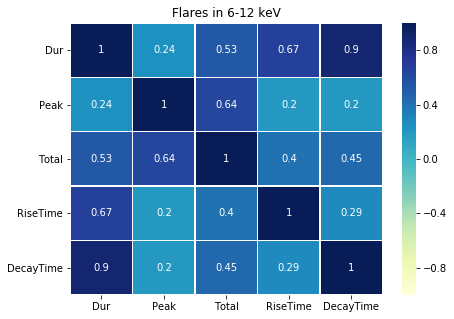

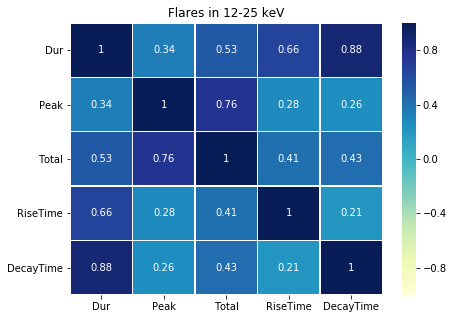

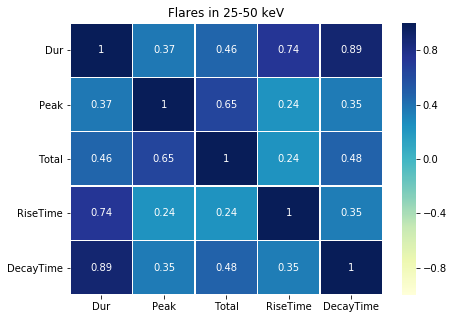

In [21]:
# Correlation between different flare parameters
# Function to plot Correlation matrix on the basis of 'Energy' range
def corr_plot(df, energy): 
    """
    Function to plot correlation matrix
    Input:
    df : dataframe
    energy : energy range
    Output:
    plots correlation plot for flares in specified energy range
    """
    print("")
    corr = df.loc[df['Energy']==energy, cols].corr()    # Correlation matrix
    plt.figure(figsize=(7,5))
    sns.heatmap(corr, vmin=-1, vmax=1, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidth=0.5, cmap="YlGnBu")
    plt.title("Flares in "+ energy + " keV")
    plt.show()

for energy in ['6-12', '12-25', '25-50']:
    corr_plot(flare, energy)

In [22]:
# Fit power law to flare parameters
import powerlaw

 ******************************* Peak Count Rates of Solar Flares *********************************


Calculating best minimal value for power law fit


For 6-12 keV energy flares :
Alpha :  3.2765835756180293
Standard error :  0.0790213695115851
Threshold value of the parameter :  333.0
Comparison with exponential distribution : 
Loglikelihood Ratio :  228.23055938942377
p value :  0.0008187184590851312



Calculating best minimal value for power law fit


For 12-25 keV energy flares :
Alpha :  2.5793686050136375
Standard error :  0.04382066109849442
Threshold value of the parameter :  752.0
Comparison with exponential distribution : 
Loglikelihood Ratio :  -22.52593192539208
p value :  0.13882419476021787

For 25-50 keV energy flares :
Alpha :  2.5671222358384265
Standard error :  0.15830325141565363
Threshold value of the parameter :  1712.0
Comparison with exponential distribution : 
Loglikelihood Ratio :  4.302280022436291
p value :  0.43544749468949817



Calculating best minimal value for power law fit


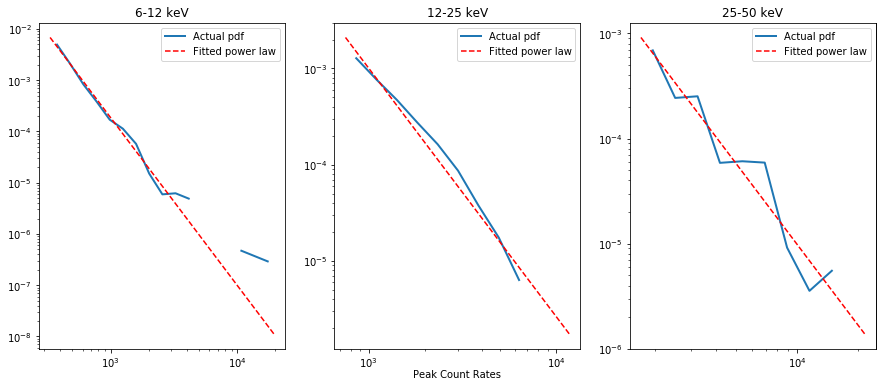

In [23]:
def power_fit(df, column, label):
    print(" *******************************", label, "of Solar Flares *********************************" )
    energies = ['6-12', '12-25', '25-50']
    fig = plt.figure(figsize=(15, 6))
    ax = fig.add_subplot(111)
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    axis = [ax1, ax2, ax3]
    ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    for energy in energies:
        data = df.loc[df['Energy']==energy, column]
        fit = powerlaw.Fit(data)
        print("For " + energy + " keV energy flares :")
        print("Alpha : " , fit.power_law.alpha)  # f(x) = A.x**(-alpha); Alpha: Exponent on x
        print("Standard error : " , fit.power_law.sigma)   # Standard error: Standard error associated with alpha
        print("Threshold value of the parameter : ", fit.power_law.xmin) # xmin: Minimum value of x used as threshold to fit the power law
        R, p = fit.distribution_compare('power_law', 'exponential') # Comparison of power law fit with exponential fit to the data
        print("Comparison with exponential distribution : ")
        print("Loglikelihood Ratio : ", R) # Tells how likely it is for the distribtuion to be of the first category
        print("p value : ", p)  # Significance value of the result of comparison
        print("")
        i = energies.index(energy)
        fit.plot_pdf(linewidth=2, label="Actual pdf", ax=axis[i])  # Plot actual probability density function on 
        # Plot fitted power law on loglog scale
        fit.power_law.plot_pdf(color='r', linestyle='--', label="Fitted power law", ax=axis[i])
        axis[i].legend()
        axis[i].set_title(energy+" keV")
    ax.set_xlabel(label)
    plt.show()
        
power_fit(flare, 'Peak', 'Peak Count Rates')

In [29]:
# Find out the Active Region where flares occur the most frequently
from collections import Counter
# Most frequent Active Region for all flares
count = Counter(flare['AR'])
active_region = pd.DataFrame({'AR':list(count.keys()), 'Frequency':list(count.values())})
print(active_region.sort_values(by='Frequency', ascending=False).head())

# Most frequent Active Region for all flares in different energy groups
def frequent_AR(df, energy):
    count = Counter(df.loc[flare['Energy']==energy,'AR'])
    active_region = pd.DataFrame({'AR':list(count.keys()), 'Frequency':list(count.values())})
    print("Energy range: ", energy, "keV")
    print(active_region.sort_values(by='Frequency', ascending=False).head())
    

for energy in flare['Energy'].unique().sort_values():
    frequent_AR(flare, energy)
    print("")

      AR  Frequency
2      0       9952
450  656        272
532  786        215
154  198        208
375  536        204
Energy range:  6-12 keV
        AR  Frequency
2        0       8713
432    656        203
513    786        185
1036  1654        169
1394  2253        168

Energy range:  12-25 keV
      AR  Frequency
2      0       1125
256  656         69
287  720         59
212  536         52
322  808         45

Energy range:  25-50 keV
       AR  Frequency
3       0         80
128  2546         10
126  2497          7
107  2297          7
92   2192          6

Energy range:  50-100 keV
     AR  Frequency
2     0          5
0   508          1
1  1897          1
3  2158          1
4  2172          1

Energy range:  100-300 keV
     AR  Frequency
0     0          4
1  2242          2
2  2297          1
3  2339          1
4  2497          1

Energy range:  300-800 keV
     AR  Frequency
0  2227          1

Energy range:  800-7000 keV
     AR  Frequency
0     0         23
4  2173   